## **Mobina Pournemat**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1
from tensorflow.image import adjust_brightness
from tensorflow.keras import layers, models
from keras.layers.merge import concatenate
from matplotlib import pyplot as plt
from skimage.transform import rotate
import tensorflow as tf
import numpy as np
import keras
import cv2

# **Loading data**

In [ ]:
!wget -O Data.npz https://zenodo.org/record/4269852/files/dermamnist.npz?download=1

--2021-08-16 18:10:50--  https://zenodo.org/record/4269852/files/dermamnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19725078 (19M) [application/octet-stream]
Saving to: ‘Data.npz’

Data.npz            100%[===================>]  18.81M  9.30MB/s    in 2.0s    

2021-08-16 18:10:54 (9.30 MB/s) - ‘Data.npz’ saved [19725078/19725078]



In [ ]:
data = np.load('Data.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [ ]:
X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7007, 28, 28, 3) (7007, 1)
(1003, 28, 28, 3) (1003, 1)
(2005, 28, 28, 3) (2005, 1)


In [ ]:
y_test_ = data['test_labels']
y_test_ = y_test_.reshape(-1,)
y_test_.shape

(2005,)

# **Visualization**

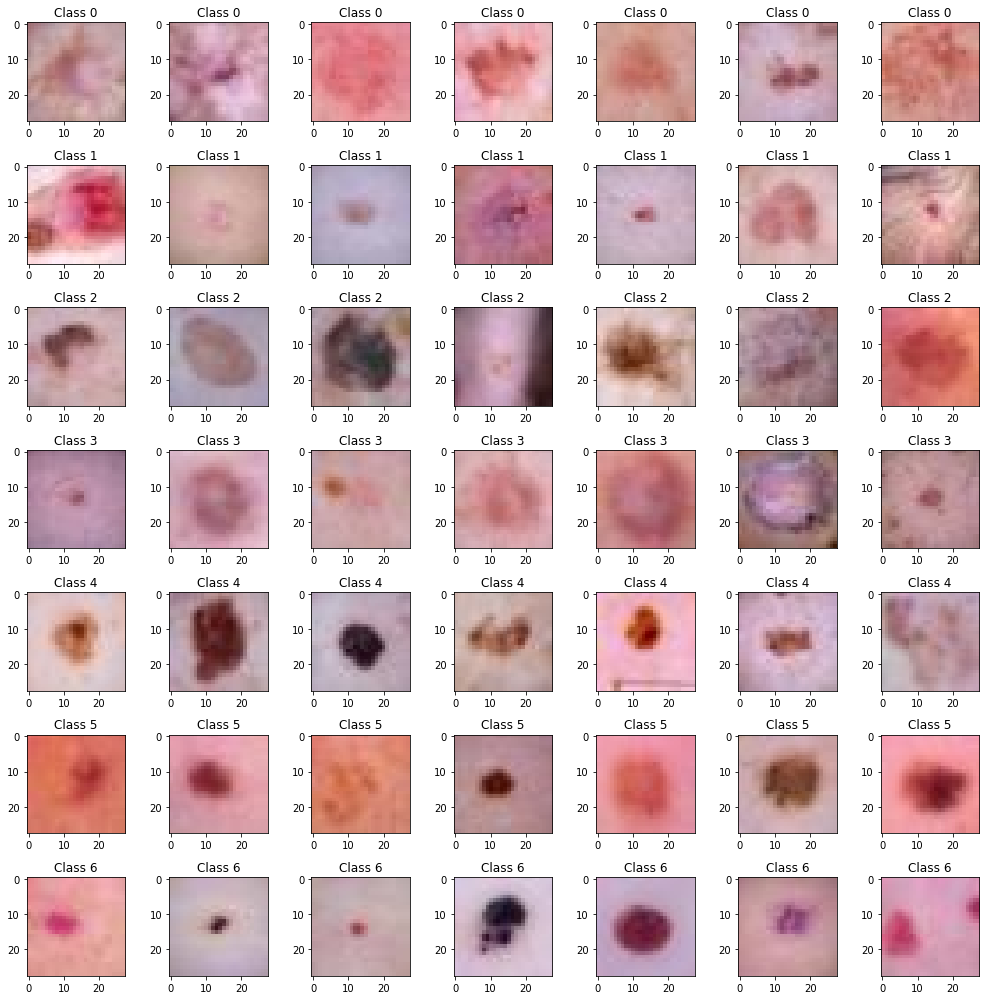

In [ ]:
no_classes = len(np.unique(y_train))
fig, axes = plt.subplots(7, 7, figsize=(14, 14))
for c in range(no_classes):
    indexes = np.where(y_train == c)[0][:no_classes]
    class_images = [X_train[i] for i in indexes]
    for i in range(no_classes):
        t = f'Class {c}'
        axes[c, i].set_title(t)
        axes[c, i].imshow(class_images[i])
plt.tight_layout()



---



For better comparison of models, I trained both MLP and CNN models. As is clear, the CNN model performs better.  Both models trained without any preprocessing on training data.

As the data is imbalanced, accuracy cannot evaluate model properly, so I used precision, recall, and confusion matrix too.

# **MLP**

In [ ]:
y_train_mlp = tf.keras.utils.to_categorical(y_train)
y_val_mlp = tf.keras.utils.to_categorical(y_val)
y_test_mlp = tf.keras.utils.to_categorical(y_test)
y_val_mlp.shape, y_test_mlp.shape, y_train_mlp.shape

((1003, 7), (2005, 7), (7007, 7))

In [ ]:
mlp = models.Sequential([
            layers.Flatten(input_shape= (28,28,3)),
            layers.Dense(3000, 'relu'),
            layers.Dense(1000, 'relu'),
            layers.Dense(7, 'softmax')
])

mlp.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', Precision(), Recall()])

mlp.fit(X_train, y_train_mlp, epochs=20, validation_data=(X_val, y_val_mlp))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 174.4786 - accuracy: 0.5022 - precision_3: 0.5058 - recall_3: 0.4978 - val_loss: 3.9902 - val_accuracy: 0.6690 - val_precision_3: 0.6690 - val_recall_3: 0.6690
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 1.4595 - accuracy: 0.6412 - precision_3: 0.7305 - recall_3: 0.4891 - val_loss: 1.0955 - val_accuracy: 0.6680 - val_precision_3: 0.8487 - val_recall_3: 0.4586
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 1.0542 - accuracy: 0.6699 - precision_3: 0.8188 - recall_3: 0.4661 - val_loss: 1.2273 - val_accuracy: 0.6690 - val_precision_3: 0.9600 - val_recall_3: 0.0479
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 1.0637 - accuracy: 0.6699 - precision_3: 0.6947 - recall_3: 0.5794 - val_loss: 1.0333 - val_accuracy: 0.6690 - val_precision_3: 0.6687 - val_recall_3: 0.6680
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - lo

In [ ]:
mlp.evaluate(X_test, y_test_mlp)

63/63 [==============================] - 0s 3ms/step - loss: 1.1363 - accuracy: 0.6688 - precision_3: 0.6693 - recall_3: 0.6673


[1.1363296508789062,
 0.6688279509544373,
 0.6693346500396729,
 0.6673316955566406]

In [ ]:
y_pred = mlp.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test_, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00       220
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00       223
           5       0.67      1.00      0.80      1341
           6       0.00      0.00      0.00        29

    accuracy                           0.67      2005
   macro avg       0.10      0.14      0.11      2005
weighted avg       0.45      0.67      0.54      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As is clear, the MLP model doesn't perform well and it predicted all data as the fifth class. (Because of a huge number of data in fifth class)

# **Sequential CNN**

## without preprocessing

In [ ]:
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_val_cnn = tf.keras.utils.to_categorical(y_val)
y_test_cnn = tf.keras.utils.to_categorical(y_test)
y_val_cnn.shape, y_test_cnn.shape, y_train_cnn.shape

((1003, 7), (2005, 7), (7007, 7))

In [ ]:
cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape= (28,28,3), padding='same', kernel_regularizer=l2(0.01)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),            
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),            
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),        
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(40, 'relu'),
            layers.Dense(7, 'softmax')
])

cnn.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy', Precision(), Recall()])

cnn.fit(X_train, y_train_cnn, epochs=20, batch_size=32, validation_data=(X_val, y_val_cnn))

Epoch 1/20
219/219 [==============================] - 32s 10ms/step - loss: 1.5888 - accuracy: 0.6655 - precision_6: 0.7589 - recall_6: 0.5517 - val_loss: 1.3953 - val_accuracy: 0.6859 - val_precision_6: 0.7887 - val_recall_6: 0.5842
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 1.3744 - accuracy: 0.6748 - precision_6: 0.8011 - recall_6: 0.5586 - val_loss: 1.3154 - val_accuracy: 0.6700 - val_precision_6: 0.8371 - val_recall_6: 0.5484
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 1.2930 - accuracy: 0.6772 - precision_6: 0.7978 - recall_6: 0.5739 - val_loss: 1.2990 - val_accuracy: 0.6790 - val_precision_6: 0.8674 - val_recall_6: 0.4955
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 1.2361 - accuracy: 0.6790 - precision_6: 0.7993 - recall_6: 0.5810 - val_loss: 1.1884 - val_accuracy: 0.6800 - val_precision_6: 0.8296 - val_recall_6: 0.5533
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - lo

In [ ]:
cnn.evaluate(X_test, y_test_cnn)

63/63 [==============================] - 0s 6ms/step - loss: 0.8604 - accuracy: 0.7077 - precision_6: 0.8168 - recall_6: 0.6025


[0.8603942394256592,
 0.7077306509017944,
 0.8167681097984314,
 0.6024937629699707]

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test_, y_pred_classes))

              precision    recall  f1-score   support

           0       0.33      0.02      0.03        66
           1       0.52      0.28      0.36       103
           2       0.37      0.39      0.38       220
           3       0.00      0.00      0.00        23
           4       0.39      0.04      0.07       223
           5       0.77      0.95      0.85      1341
           6       0.45      0.52      0.48        29

    accuracy                           0.71      2005
   macro avg       0.41      0.31      0.31      2005
weighted avg       0.64      0.71      0.65      2005



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As is clear, the CNN model performed great in predicting data from the fifth class. that's because of a huge number of data from the fifth class.
and the model was so bad in predicting the third class data. because we have little data from the third class, the model didn't have enough data to learn it better. Also, we have few data from sixth class but this class has much easier data in comparison to third class. So the model performed well at predicting sixth class data.
In some classes, such as 0 and 4 the recall is so low but the precision isn't. what happend is, for example, the model predicted one image as fourth class (and did it properly) and it missed other images from fourth class. same thing for class zero.

## Preprocessing on data

### Useless methods

Like I said, the data is totally imbalanced and there are so much data from the fifth class. to get the dataset more balanced, I removed some of the data from the fifth class. Then I augmented data according to their distribution to other classes, to have more balanced classes. (And ImageDataGenerator module didn't work because of imbalances)

This dataset is so specific, and data augmentation doesn't work well. because of that, using flipping, rotation, brightness changing, and, etc. doesn't make any change in training approach.
I tried many preprocessing methods, but none of them didn't make impressive change. Thus, I used the original data with just a reshape to 32 pixels.

In [ ]:
y_train_pp = y_train.reshape(-1,)
y_val_pp = y_val.reshape(-1,)
y_test_pp = y_test.reshape(-1,)

In [ ]:
def get_classes_dist(y):
    count = [0 for i in range(7)]
    for i in y:
      count[i] += 1
    return count


In [ ]:
get_classes_dist(y_train_pp)

[228, 359, 769, 80, 779, 4693, 99]

Remove some data from fifth class

In [ ]:
count = 1
i = 0
X_train2 = X_train
y_train2 = y_train
indexes = []

while count <= (2800):
    if y_train[i] == 5:
        indexes.append(i)
        count += 1
    i += 1

X_train2 = np.delete(X_train2, indexes, axis=0)
y_train2 = np.delete(y_train2, indexes, axis=0)

In [ ]:
get_classes_dist(y_train2.reshape(-1,))

[228, 359, 769, 80, 779, 1893, 99]

Augmenting other classes according to distribution of data in classes

In [ ]:
X_augmented = X_train2
y_augmented = y_train2.reshape(-1,)

for i in range(X_train2.shape[0]):
    y = y_train2.reshape(-1,)[i]
    if y == 5:
        continue
    elif y == 0:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y], axis=0)
    elif y == 1:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], adjust_brightness(X_train2[i], delta=0.3),rotate(X_train2[i], 45)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y], axis=0)
    elif y == 2:
         X_augmented = np.append(X_augmented, [adjust_brightness(X_train2[i], delta=0.3)], axis=0)
         y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 3:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90), adjust_brightness(X_train2[i], delta=-0.6), rotate(X_train2[i], 135), adjust_brightness(X_train2[i], delta=0.6)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y, y, y, y], axis=0)
    elif y == 4:
        X_augmented = np.append(X_augmented, [adjust_brightness(X_train2[i], delta=0.3)], axis=0)
        y_augmented = np.append(y_augmented, [y], axis=0)
    elif y == 6:
        X_augmented = np.append(X_augmented, [X_train2[i][:, ::-1,:], X_train2[i][::-1, :,:], adjust_brightness(X_train2[i], delta=0.3), adjust_brightness(X_train2[1], delta=-0.3)], axis=0)
        X_augmented = np.append(X_augmented, [rotate(X_train2[i], 45), rotate(X_train2[i], 90), adjust_brightness(X_train2[i], delta=-0.6), rotate(X_train2[i], 135), adjust_brightness(X_train2[i], delta=0.6)], axis=0)
        y_augmented = np.append(y_augmented, [y ,y, y, y, y, y, y, y, y], axis=0)


X_augmented.shape, y_augmented.shape    

((9811, 28, 28, 3), (9811,))

In [ ]:
get_classes_dist(y_augmented)

[1596, 1436, 1538, 800, 1558, 1893, 990]

In [ ]:
def unison_shuffle(a, b):
    inx = np.random.permutation(a.shape[0])
    return a[inx], b[inx]

X_augmented, y_augmented = unison_shuffle(X_augmented, y_augmented)

In [ ]:
X_augmented = X_augmented / 255
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [ ]:
y_augmented_ = tf.keras.utils.to_categorical(y_augmented)
y_augmented_.shape

(9811, 7)

In [ ]:
cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', input_shape= (28,28,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, 'elu'),
            layers.Dense(7, 'softmax')
])

cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

hist = cnn.fit(X_augmented, y_augmented_, epochs=40, batch_size=32, validation_data=(X_val, y_val_cnn))

Epoch 1/40
307/307 [==============================] - 4s 9ms/step - loss: 2.7852 - accuracy: 0.2634 - precision_10: 0.3313 - recall_10: 0.0903 - val_loss: 1.9080 - val_accuracy: 0.4148 - val_precision_10: 0.9296 - val_recall_10: 0.3290
Epoch 2/40
307/307 [==============================] - 2s 7ms/step - loss: 2.1424 - accuracy: 0.3281 - precision_10: 0.7014 - recall_10: 0.1037 - val_loss: 1.7844 - val_accuracy: 0.4855 - val_precision_10: 0.9265 - val_recall_10: 0.3519
Epoch 3/40
307/307 [==============================] - 2s 7ms/step - loss: 2.0177 - accuracy: 0.3714 - precision_10: 0.7192 - recall_10: 0.1248 - val_loss: 1.7069 - val_accuracy: 0.5145 - val_precision_10: 0.9091 - val_recall_10: 0.3490
Epoch 4/40
307/307 [==============================] - 2s 7ms/step - loss: 1.9211 - accuracy: 0.4075 - precision_10: 0.6931 - recall_10: 0.1664 - val_loss: 1.5686 - val_accuracy: 0.5932 - val_precision_10: 0.8593 - val_recall_10: 0.3958
Epoch 5/40
307/307 [==============================] - 2s

In [ ]:
cnn.evaluate(X_test, y_test_cnn)

63/63 [==============================] - 0s 6ms/step - loss: 1.1965 - accuracy: 0.7217 - precision_10: 0.7707 - recall_10: 0.6773


[1.1965128183364868,
 0.7216957807540894,
 0.7707151174545288,
 0.6773067116737366]

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test_, y_pred_classes))

              precision    recall  f1-score   support

           0       0.39      0.44      0.41        66
           1       0.37      0.52      0.43       103
           2       0.48      0.55      0.51       220
           3       0.21      0.30      0.25        23
           4       0.43      0.27      0.33       223
           5       0.88      0.86      0.87      1341
           6       0.57      0.72      0.64        29

    accuracy                           0.72      2005
   macro avg       0.47      0.52      0.49      2005
weighted avg       0.73      0.72      0.72      2005



As is clear, with data augmentation, the problem of zero recall in some classes gets better but still data augmentation didn't help much.

### Useful methods:

In [ ]:
X_train = np.array([cv2.resize(img, (32, 32)) for img in X_train])
X_val = np.array([cv2.resize(img, (32, 32)) for img in X_val])
X_test = np.array([cv2.resize(img, (32, 32)) for img in X_test])
X_train.shape, X_val.shape, X_test.shape

((7007, 32, 32, 3), (1003, 32, 32, 3), (2005, 32, 32, 3))

In [ ]:
# y_augmented = tf.keras.utils.to_categorical(y_augmented)
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)
y_val.shape, y_test.shape, y_train.shape

((1003, 7), (2005, 7), (7007, 7))

## Training model

I tried different activation functions such as relu, sigmoid, tanh, elu, selu and finally relu, tanh and elu performed better and elu was the best. Also, I tried l1 regularization and differnt values of strides, but it didn't work out. 
I tested the different number of layers and filter sizes and, I found it the best. Moreover, I realized that the learning rate is high, and with decreasing that, I achieved better results.
Also, my model got overfit to the data, so I used dropout and regularization to avoid that.

In [ ]:
cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, 'elu'),
            layers.Dense(7, 'softmax')
])

cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])



In [ ]:
hist = cnn.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/60
219/219 [==============================] - 4s 10ms/step - loss: 2.0948 - accuracy: 0.6105 - precision_11: 0.6395 - recall_11: 0.5457 - val_loss: 1.5400 - val_accuracy: 0.6700 - val_precision_11: 0.7632 - val_recall_11: 0.5045
Epoch 2/60
219/219 [==============================] - 2s 7ms/step - loss: 1.5346 - accuracy: 0.6609 - precision_11: 0.7368 - recall_11: 0.5596 - val_loss: 1.5200 - val_accuracy: 0.6720 - val_precision_11: 0.9108 - val_recall_11: 0.3868
Epoch 3/60
219/219 [==============================] - 2s 7ms/step - loss: 1.4714 - accuracy: 0.6689 - precision_11: 0.7746 - recall_11: 0.5650 - val_loss: 1.5193 - val_accuracy: 0.6082 - val_precision_11: 0.9181 - val_recall_11: 0.3799
Epoch 4/60
219/219 [==============================] - 2s 7ms/step - loss: 1.4318 - accuracy: 0.6766 - precision_11: 0.7892 - recall_11: 0.5691 - val_loss: 1.3651 - val_accuracy: 0.6899 - val_precision_11: 0.8484 - val_recall_11: 0.5414
Epoch 5/60
219/219 [==============================] - 2

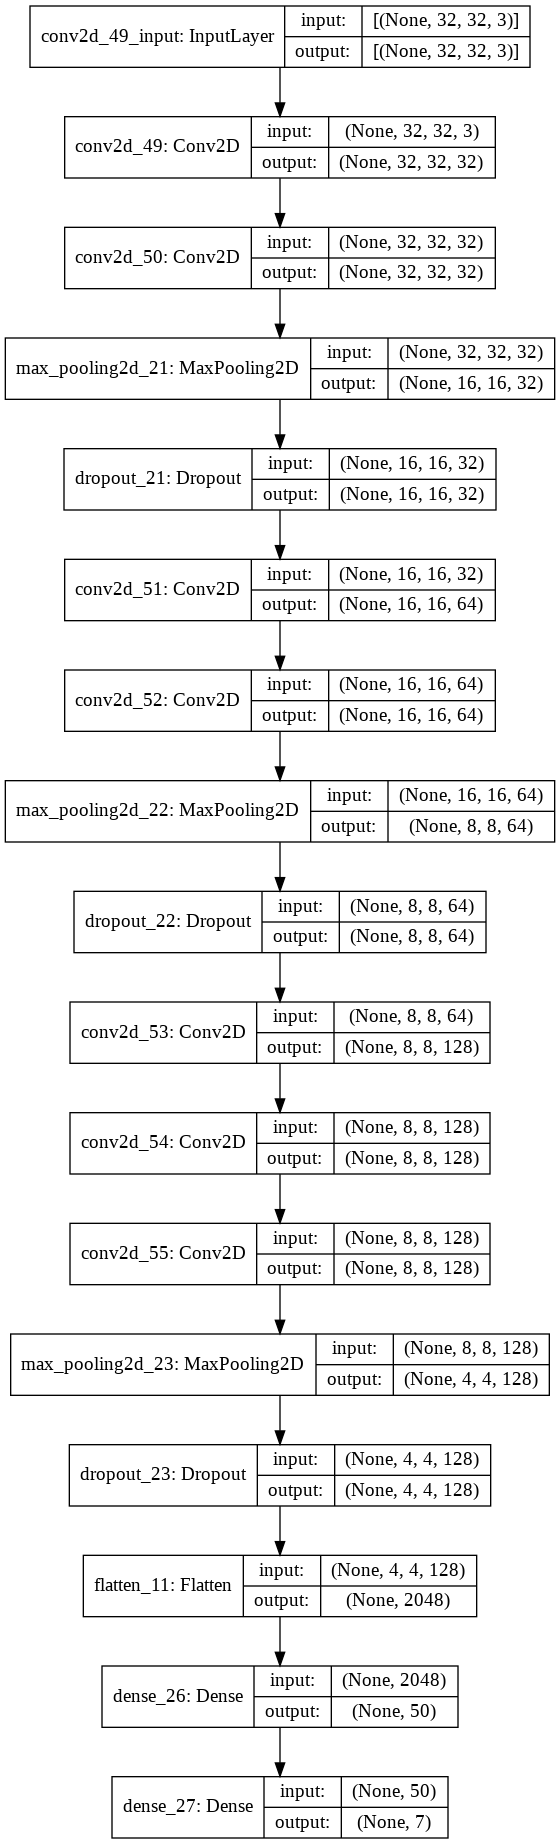

In [ ]:
tf.keras.utils.plot_model(cnn, show_shapes=True)

## Evaluating model

In [ ]:
cnn.evaluate(X_test, y_test)

63/63 [==============================] - 0s 7ms/step - loss: 1.1095 - accuracy: 0.7536 - precision_11: 0.7785 - recall_11: 0.7312


[1.109533429145813, 0.7536159753799438, 0.7785449028015137, 0.7311720848083496]

In [ ]:
y_pred = cnn.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test_, y_pred_classes))

              precision    recall  f1-score   support

           0       0.58      0.29      0.38        66
           1       0.58      0.39      0.47       103
           2       0.50      0.53      0.51       220
           3       0.71      0.22      0.33        23
           4       0.46      0.39      0.42       223
           5       0.85      0.91      0.88      1341
           6       0.82      0.62      0.71        29

    accuracy                           0.75      2005
   macro avg       0.64      0.48      0.53      2005
weighted avg       0.74      0.75      0.74      2005



The description of analyzing confusion matrix same as said before.

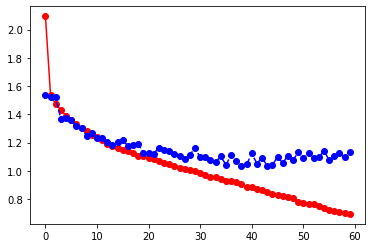

In [ ]:
plt.plot(hist.history['loss'], 'r-o')
plt.plot(hist.history['val_loss'], 'b--o')

The model is going to overfit to the training data, but it's not overfit completely now.

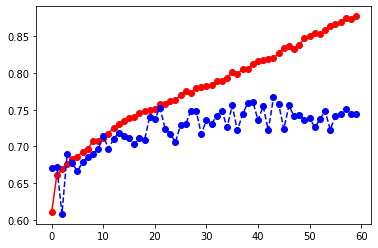

In [ ]:
plt.plot(hist.history['accuracy'], 'r-o')
plt.plot(hist.history['val_accuracy'], 'b--o')

#**Functional CNN**

In comparison to Sequential, the functional model is more flexible and got better results.

## Training model

In [ ]:
img_inputs = keras.Input(shape=(32,32,3))
conv_1 = keras.layers.Conv2D(32, (3, 3), activation='relu')(img_inputs)
conv_2 = keras.layers.Conv2D(32, (3, 3), activation='relu')(conv_1)
maxpool_1 = keras.layers.MaxPooling2D((2, 2))(conv_1)
conv_3 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
maxpool_2 = keras.layers.MaxPooling2D((2, 2))(conv_3)
flat1 = keras.layers.Flatten()(maxpool_2)
conv_4 = keras.layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
maxpool_3 = keras.layers.MaxPooling2D((2, 2))(conv_4)
flat2 = keras.layers.Flatten()(maxpool_3)
merge = concatenate([flat1, flat2])
hidden1 = keras.layers.Dense(50, 'relu')(merge)
output = keras.layers.Dense(7, 'softmax')(hidden1)

model = keras.Model(inputs=img_inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
219/219 [==============================] - 2s 9ms/step - loss: 0.2610 - accuracy: 0.9031 - precision_18: 0.8817 - recall_18: 0.7496 - val_loss: 1.6463 - val_accuracy: 0.6879 - val_precision_18: 0.8820 - val_recall_18: 0.7515
Epoch 2/30
219/219 [==============================] - 1s 5ms/step - loss: 0.2165 - accuracy: 0.9202 - precision_18: 0.8825 - recall_18: 0.7536 - val_loss: 1.6781 - val_accuracy: 0.6889 - val_precision_18: 0.8831 - val_recall_18: 0.7558
Epoch 3/30
219/219 [==============================] - 1s 5ms/step - loss: 0.2046 - accuracy: 0.9298 - precision_18: 0.8837 - recall_18: 0.7580 - val_loss: 1.6958 - val_accuracy: 0.6989 - val_precision_18: 0.8844 - val_recall_18: 0.7603
Epoch 4/30
219/219 [==============================] - 1s 6ms/step - loss: 0.2121 - accuracy: 0.9269 - precision_18: 0.8850 - recall_18: 0.7624 - val_loss: 1.7694 - val_accuracy: 0.6869 - val_precision_18: 0.8855 - val_recall_18: 0.7644
Epoch 5/30
219/219 [==============================] - 1s

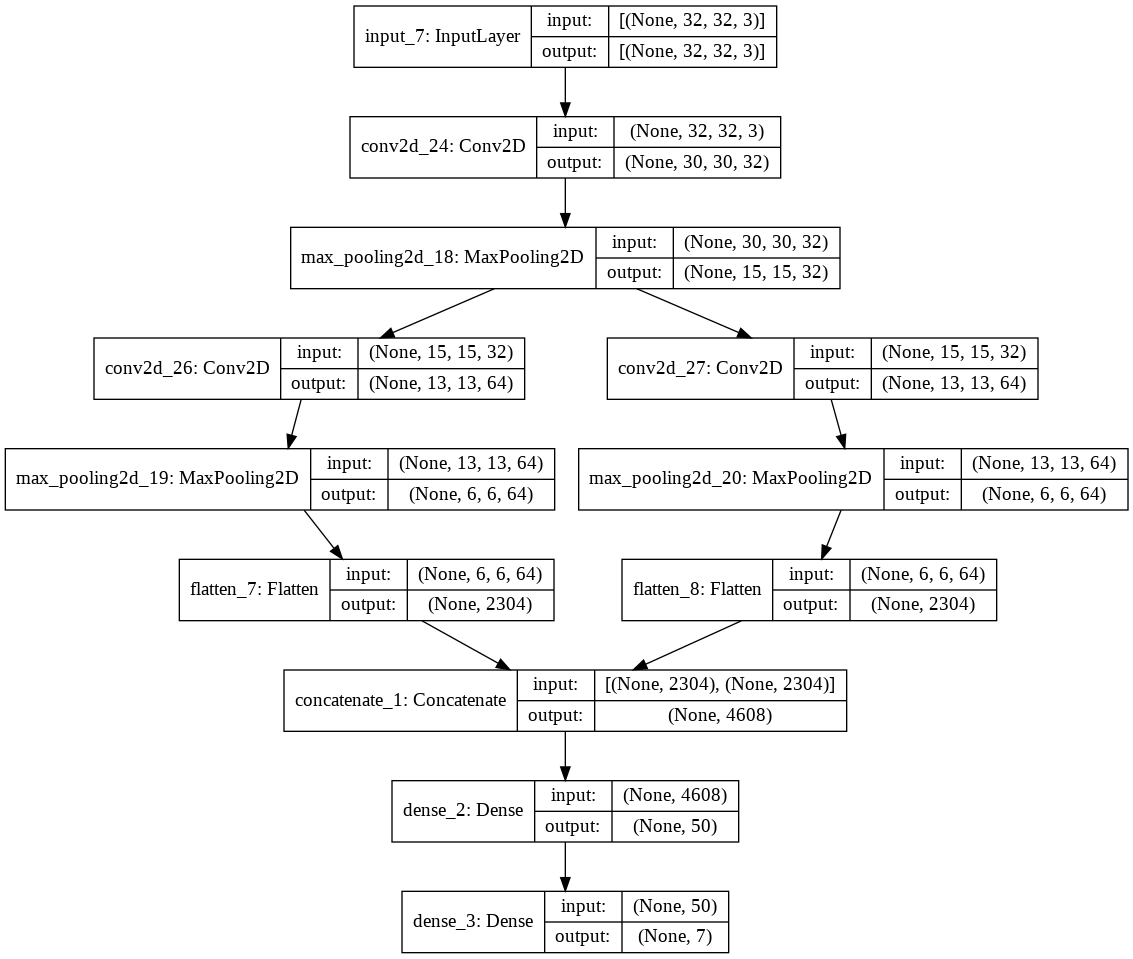

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Evaluation model

In [ ]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 4ms/step - loss: 2.9726 - accuracy: 0.6658 - precision_18: 0.9044 - recall_18: 0.8312


[2.9726083278656006, 0.665835440158844, 0.9044265151023865, 0.8311998844146729]

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test_, y_pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.30      0.29        66
           1       0.33      0.32      0.33       103
           2       0.39      0.35      0.37       220
           3       0.31      0.22      0.26        23
           4       0.29      0.35      0.32       223
           5       0.84      0.83      0.83      1341
           6       0.53      0.31      0.39        29

    accuracy                           0.67      2005
   macro avg       0.42      0.38      0.40      2005
weighted avg       0.67      0.67      0.67      2005



# **Change in activation function**

As is clear, the elu activation function has better performance among others.

In [ ]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'selu']
af = []
for f in activation_functions:
    cnn = models.Sequential([
            layers.Conv2D(filters=32, kernel_size=(3,3), activation=f, padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=32, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=128, kernel_size=(3,3), activation=f, padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, activation=f),
            layers.Dense(7, 'softmax')
    ])

    cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
    print()
    print('--------------------- Activation function: ', f, '------------------------')
    cnn.evaluate(X_test, y_test)
    print('-------------------------------------------------------------------------------')
    print()


Epoch 1/30
219/219 [==============================] - 4s 11ms/step - loss: 2.3431 - accuracy: 0.6011 - precision_12: 0.6326 - recall_12: 0.5252 - val_loss: 1.7639 - val_accuracy: 0.6690 - val_precision_12: 0.9750 - val_recall_12: 0.2333
Epoch 2/30
219/219 [==============================] - 2s 8ms/step - loss: 1.5916 - accuracy: 0.6619 - precision_12: 0.7177 - recall_12: 0.5649 - val_loss: 1.6585 - val_accuracy: 0.6690 - val_precision_12: 0.9488 - val_recall_12: 0.3141
Epoch 3/30
219/219 [==============================] - 2s 8ms/step - loss: 1.5167 - accuracy: 0.6646 - precision_12: 0.7405 - recall_12: 0.5499 - val_loss: 1.5878 - val_accuracy: 0.6690 - val_precision_12: 0.9364 - val_recall_12: 0.3081
Epoch 4/30
219/219 [==============================] - 2s 8ms/step - loss: 1.4836 - accuracy: 0.6702 - precision_12: 0.7587 - recall_12: 0.5554 - val_loss: 1.4898 - val_accuracy: 0.6690 - val_precision_12: 0.8865 - val_recall_12: 0.4048
Epoch 5/30
219/219 [==============================] - 2

# **Change in filter size**

As is clear, using 64, 128, 256 filters, respectively, has better results among others.

In [ ]:
filter_size = [[8, 16, 32], [16, 32, 64], [64, 128, 256], [20, 60, 120]]
fs = []
for f in filter_size:
    cnn = models.Sequential([
            layers.Conv2D(filters=f[0], kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=f[0], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=f[1], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=f[1], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Conv2D(filters=f[2], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=f[2], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=f[2], kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2)),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, activation='elu'),
            layers.Dense(7, 'softmax')
    ])

    cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
    print()
    print('--------------------- Filter sizes: ', f, '------------------------')
    cnn.evaluate(X_test, y_test)
    print('-------------------------------------------------------------------------------')
    print()

Epoch 1/30
219/219 [==============================] - 3s 10ms/step - loss: 3.7731 - accuracy: 0.4902 - precision_15: 0.5017 - recall_15: 0.4707 - val_loss: 1.5726 - val_accuracy: 0.6690 - val_precision_15: 0.6690 - val_recall_15: 0.6690
Epoch 2/30
219/219 [==============================] - 1s 7ms/step - loss: 1.8409 - accuracy: 0.5590 - precision_15: 0.5902 - recall_15: 0.4928 - val_loss: 1.2823 - val_accuracy: 0.6690 - val_precision_15: 0.6737 - val_recall_15: 0.6650
Epoch 3/30
219/219 [==============================] - 2s 7ms/step - loss: 1.4970 - accuracy: 0.6141 - precision_15: 0.6535 - recall_15: 0.5260 - val_loss: 1.2578 - val_accuracy: 0.6690 - val_precision_15: 0.6878 - val_recall_15: 0.6391
Epoch 4/30
219/219 [==============================] - 2s 7ms/step - loss: 1.3868 - accuracy: 0.6395 - precision_15: 0.6686 - recall_15: 0.5517 - val_loss: 1.2563 - val_accuracy: 0.6690 - val_precision_15: 0.7098 - val_recall_15: 0.6072
Epoch 5/30
219/219 [==============================] - 2

# **Change in kernel size**

As is clear, (2, 2) kernel size has better results among others.

In [ ]:
kernel_size = [(2, 2), (3, 3)]

for f in kernel_size:
    cnn = models.Sequential([
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D(f),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D(f),
            layers.Dropout(0.2),
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D(f),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, activation='elu'),
            layers.Dense(7, 'softmax')
    ])

    cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
    print()
    print('--------------------- Kernel size: ', f, '------------------------')
    cnn.evaluate(X_test, y_test)
    print('---------------------------------------------------------------------------')
    print()

Epoch 1/30
219/219 [==============================] - 4s 14ms/step - loss: 2.4575 - accuracy: 0.6315 - precision_24: 0.6766 - recall_24: 0.5529 - val_loss: 1.9745 - val_accuracy: 0.6680 - val_precision_24: 0.8963 - val_recall_24: 0.3878
Epoch 2/30
219/219 [==============================] - 3s 12ms/step - loss: 1.9681 - accuracy: 0.6662 - precision_24: 0.7318 - recall_24: 0.5776 - val_loss: 2.4175 - val_accuracy: 0.4367 - val_precision_24: 0.4471 - val_recall_24: 0.3958
Epoch 3/30
219/219 [==============================] - 3s 12ms/step - loss: 1.9060 - accuracy: 0.6735 - precision_24: 0.7682 - recall_24: 0.5751 - val_loss: 2.0464 - val_accuracy: 0.5823 - val_precision_24: 0.6653 - val_recall_24: 0.4776
Epoch 4/30
219/219 [==============================] - 3s 12ms/step - loss: 1.8436 - accuracy: 0.6760 - precision_24: 0.7928 - recall_24: 0.5804 - val_loss: 1.9373 - val_accuracy: 0.6261 - val_precision_24: 0.7293 - val_recall_24: 0.5344
Epoch 5/30
219/219 [==============================] 

# **Change in strides**

As is clear, the value of 3 is suitable for stride and it got better results.

In [ ]:
strides = [1, 2, 3, 4]

for s in strides:
    cnn = models.Sequential([
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
            layers.MaxPooling2D((2,2), strides=s),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
            layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
            layers.MaxPooling2D((2,2), strides=s),
            layers.Dropout(0.2),
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
            layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
            layers.MaxPooling2D((2,2), strides=s),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(50, activation='elu'),
            layers.Dense(7, 'softmax')
    ])

    cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
    print('--------------------- Strides: ', s, '------------------------')
    cnn.evaluate(X_test, y_test)
    print('----------------------------------------------------')


Epoch 1/30
219/219 [==============================] - 15s 61ms/step - loss: 2.8286 - accuracy: 0.6401 - precision_26: 0.7178 - recall_26: 0.5387 - val_loss: 20.6083 - val_accuracy: 0.0339 - val_precision_26: 0.0339 - val_recall_26: 0.0339
Epoch 2/30
219/219 [==============================] - 12s 56ms/step - loss: 1.9204 - accuracy: 0.6735 - precision_26: 0.7890 - recall_26: 0.5554 - val_loss: 12.8944 - val_accuracy: 0.0698 - val_precision_26: 0.0662 - val_recall_26: 0.0628
Epoch 3/30
219/219 [==============================] - 12s 56ms/step - loss: 1.8687 - accuracy: 0.6810 - precision_26: 0.7964 - recall_26: 0.5612 - val_loss: 11.5772 - val_accuracy: 0.2453 - val_precision_26: 0.2436 - val_recall_26: 0.2373
Epoch 4/30
219/219 [==============================] - 12s 56ms/step - loss: 1.8161 - accuracy: 0.6815 - precision_26: 0.8030 - recall_26: 0.5741 - val_loss: 11.6428 - val_accuracy: 0.1286 - val_precision_26: 0.1258 - val_recall_26: 0.1196
Epoch 5/30
219/219 [========================

# **Average pooling**

Max pooling gets better results than average pooling and it is shown below.

In [ ]:
cnn = models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', input_shape= (32,32,3), kernel_regularizer=l2(0.001)),
        layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),         
        layers.AveragePooling2D((2,2), strides=3),
        layers.Dropout(0.2),
        layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),
        layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),          
        layers.AveragePooling2D((2,2), strides=3),
        layers.Dropout(0.2),
        layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
        layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)), 
        layers.Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same', kernel_regularizer=l2(0.001)),       
        layers.AveragePooling2D((2,2), strides=3),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(50, activation='elu'),
        layers.Dense(7, 'softmax')
])

cnn.compile(optimizer=keras.optimizers.Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))
cnn.evaluate(X_test, y_test)

Epoch 1/30
219/219 [==============================] - 4s 12ms/step - loss: 2.1085 - accuracy: 0.6489 - precision_31: 0.7023 - recall_31: 0.5622 - val_loss: 1.9474 - val_accuracy: 0.6849 - val_precision_31: 0.9157 - val_recall_31: 0.4118
Epoch 2/30
219/219 [==============================] - 2s 10ms/step - loss: 1.9132 - accuracy: 0.6688 - precision_31: 0.7702 - recall_31: 0.5547 - val_loss: 1.9979 - val_accuracy: 0.5603 - val_precision_31: 0.7487 - val_recall_31: 0.4337
Epoch 3/30
219/219 [==============================] - 2s 10ms/step - loss: 1.8460 - accuracy: 0.6749 - precision_31: 0.7885 - recall_31: 0.5642 - val_loss: 1.7990 - val_accuracy: 0.6909 - val_precision_31: 0.8569 - val_recall_31: 0.5374
Epoch 4/30
219/219 [==============================] - 2s 10ms/step - loss: 1.7903 - accuracy: 0.6847 - precision_31: 0.7995 - recall_31: 0.5793 - val_loss: 1.7675 - val_accuracy: 0.6810 - val_precision_31: 0.8567 - val_recall_31: 0.5184
Epoch 5/30
219/219 [==============================] 

[1.243062973022461, 0.735162079334259, 0.7952802181243896, 0.6723191738128662]